# Section 5b: GaAs solar cell

## Fitting the EQE of a GaAs solar cell

First we need to set up the calculation, so we import the libraries we need and some
semiconductor material properties.  Our solar cell has a single layer SiN
anti-reflection coating, an Al$_{0.8}$GaAs window layer and GaAs p/n absorber regions.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from solcore import siUnits, material, si
from solcore.solar_cell import SolarCell
from solcore.structure import Junction, Layer
from solcore.solar_cell_solver import solar_cell_solver
from solcore.light_source import LightSource
from pathlib import Path

def this_dir_file(f):
    file_path = Path.cwd()
    return file_path / "data" /  f

qeData = np.loadtxt(this_dir_file("QT1405R.csv"), unpack=True, delimiter=",")

# Define the solar spectrum we wish to use for Light-IV calculations
wl = np.linspace(300, 900, 400) * 1e-9  # Define the wavelength range of interest
am15spectrum = LightSource(source_type='standard',version='AM1.5g',x=wl,output_units='photon_flux_per_m')

# Define the materials we use for the calculation
ARC = material("Si3N4")()
AlGaAs = material("AlGaAs")
window_material = AlGaAs(Al=0.80)
GaAs = material("GaAs")

# Configure the GaAs materials, n & p type.
gaas_n_material = GaAs(Nd=siUnits(3e18, "cm-3"),
                       hole_diffusion_length=si("500nm"),
                       hole_mobility=5e-2
                       )
gaas_p_material = GaAs(Na=siUnits(1e17, "cm-3"),
                       electron_diffusion_length=si("5um"),
                       electron_mobility=5e-2
                       )

We now want to build the solar cell from these layers.  We start with the MgF2/ZnS AR coating, then the window layer, then GaAs p-doped emitter and finally the GaAs n-doped base.  It is here, in the solar cell structure that we specify the layer thicknesses.

The default thicknesses below are not optimum and do not fit the EQE data at all!  Try adjusting the thicknesses for the AR coating and the component layers to better fit the EQE data.

Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...


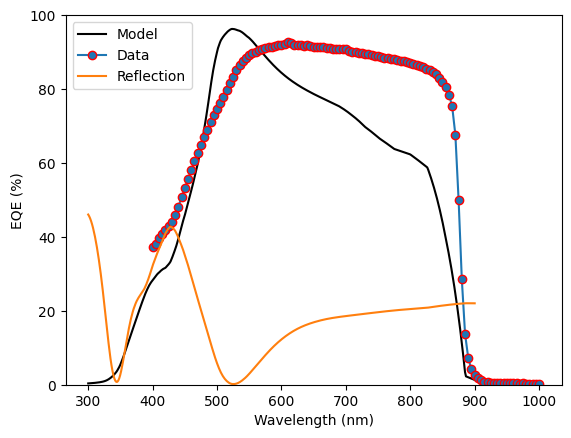

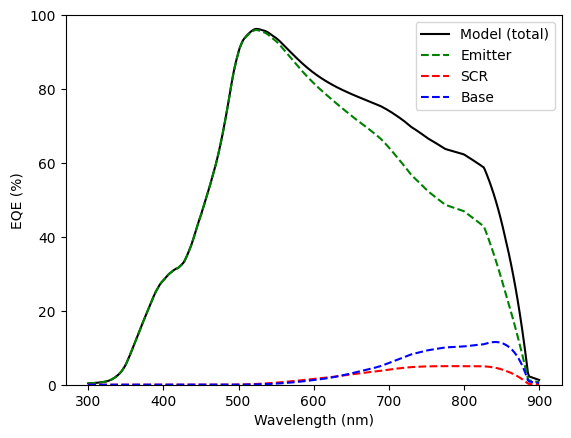

In [6]:
# Configure the solar cell layer stack
solar_cell = SolarCell(
    [Layer(si("200nm"), ARC),
     Junction([Layer(si("55nm"), material=window_material, role='window'),
                    Layer(si("800nm"), material=gaas_p_material, role='emitter'),
                  Layer(si("3000nm"), material=gaas_n_material, role='base'),
                  ], sn=1, sp=1, kind='DA')
     ], shading=0.02, cell_area=1 / 1e4)


# Calculate the solar cell QE
solar_cell_solver(solar_cell, 'qe', user_options={'wavelength': wl,'optics_method': 'TMM'})

# Plot the QE - model and data
plt.figure(1)
plt.plot(wl * 1e9, solar_cell[1].eqe(wl) * 100, 'k', label='Model')
plt.plot(qeData[0],qeData[1]*100,marker="o",markeredgecolor="red", label='Data')
plt.plot(wl * 1e9, solar_cell.reflected*100, label='Reflection')
plt.legend()
plt.ylim(0, 100)
plt.ylabel('EQE (%)')
plt.xlabel('Wavelength (nm)')

plt.show()

# Plot the QE - contributions of the base, SCR (space charge region), and emitter
plt.figure(1)
plt.plot(wl * 1e9, solar_cell[1].eqe(wl) * 100, 'k', label='Model (total)')
plt.plot(wl * 1e9, solar_cell[1].eqe_emitter(wl) * 100, '--g', label='Emitter')
plt.plot(wl * 1e9, solar_cell[1].eqe_scr(wl) * 100, '--r', label='SCR')
plt.plot(wl * 1e9, solar_cell[1].eqe_base(wl) * 100, '--b', label='Base')
plt.legend()
plt.ylim(0, 100)
plt.ylabel('EQE (%)')
plt.xlabel('Wavelength (nm)')

plt.show()

## Is there a better design for this solar GaAs cell?

Now that you have fitted the EQE, let's calculate the efficiency under AM1.5G.  Start with the same values you used above for the layer thicknesses.  Can you design a better GaAs solar cell ?!

Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


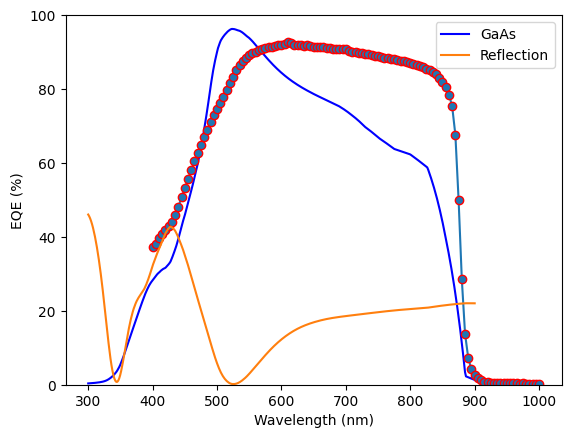

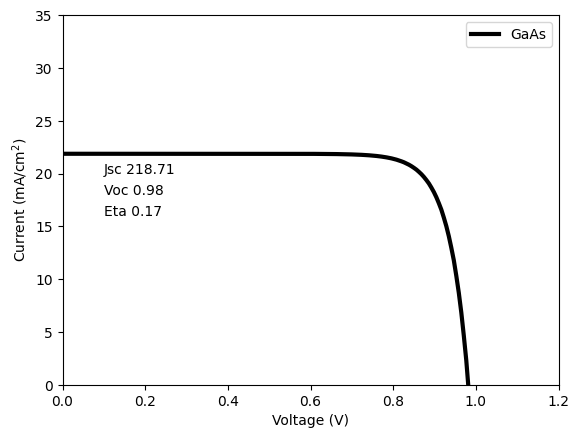

In [7]:
# Configure the solar cell layer stack
solar_cell = SolarCell(
    [Layer(si("200nm"), ARC),
     Junction([Layer(si("55nm"), material=window_material, role='window'),
                    Layer(si("800nm"), material=gaas_p_material, role='emitter'),
                  Layer(si("3000nm"), material=gaas_n_material, role='base'),
                  ], sn=1, sp=1, kind='DA')
     ], shading=0.02, cell_area=1 / 1e4)


# Calculate the solar cell QE
solar_cell_solver(solar_cell, 'qe', user_options={'wavelength': wl,'optics_method': 'TMM'})

# Plot the QE
plt.figure(1)
plt.plot(wl * 1e9, solar_cell[1].eqe(wl) * 100, 'b', label='GaAs')
plt.plot(qeData[0],qeData[1]*100,marker="o",markeredgecolor="red")
plt.plot(wl * 1e9, solar_cell.reflected*100, label='Reflection')
plt.legend()
plt.ylim(0, 100)
plt.ylabel('EQE (%)')
plt.xlabel('Wavelength (nm)')

# Plot the Light-IV
V = np.linspace(0, 1.2, 200)
solar_cell_solver(solar_cell, 'iv', user_options={'voltages': V, 'light_iv': True, 'wavelength': wl,
                                                  'optics_method': 'TMM','light_source':am15spectrum,
                                                  'mpp':True})

plt.figure(2)
plt.plot(V, solar_cell.iv['IV'][1]/10, 'k', linewidth=3, label='GaAs')

plt.legend()
plt.ylim(0, 35)
plt.xlim(0, 1.2)
plt.ylabel('Current (mA/cm$^2$)')
plt.xlabel('Voltage (V)')
plt.text(0.1,20,f'Jsc {solar_cell.iv.Isc:.2f}')
plt.text(0.1,18,f'Voc {solar_cell.iv.Voc:.2f}')
plt.text(0.1,16,f'Eta {solar_cell.iv.Eta:.2f}')

plt.show()